# Lab 3: EDA and Data Prep

Exploratory Data Analysis (EDA) is the initial phase of data analysis, focusing on understanding data characteristics, patterns, and relationships through visualizations and summaries. Data Preparation in machine learning involves preprocessing raw data to ensure its suitability for model training, including tasks like handling missing values, encoding variables, scaling features, and splitting data for training and testing. Both EDA and Data Preparation are crucial stages for extracting insights and preparing data for machine learning models.

### Exercise overview

In this exercise, you'll explore the dataset through EDA, uncovering its patterns and relationships. You'll also perform tasks like data preprocessing, handling missing values, and feature engineering to make the data ready for machine learning training.

### Helpful links
- [Data Wrangler in Microsoft Fabric](https://aka.ms/fabric/datawrangler)

## Pre-Requisite

For this Exercise, we expect that you have completed and ran **Lab 1: Access your data through semantic link**. 


## Step 1: Setup your notebook

### Select Lakehouse
First, add the Lakehouse you created from the prior lab exercise.

![image-alt-text](https://synapseaisolutionsa.blob.core.windows.net/public/Fabric-Conference/add-lakehouse.png)

### Select environment or install within session
![Select Environment and then select your environment from the list](https://synapseaisolutionsa.blob.core.windows.net/public/Fabric-Conference/AttachEnv.png)

## Step 2: Load the data as a Spark DataFrame

Load the data that you have created and saved in the lakehouse from the previous notebook.

In [1]:
df = spark.sql("SELECT * FROM FC_Workshop.churnfromsemanticlink")
display(df)

StatementMeta(, d5f065df-11e8-423f-bb4a-27cb961a4831, 3, Finished, Available)

SynapseWidget(Synapse.DataFrame, 40c83d97-4edc-4cd9-a823-b83fc5af0a1d)

Convert the spark DataFrame to pandas DataFrame for easier processing and visualization.

In [2]:
df = df.toPandas()

StatementMeta(, d5f065df-11e8-423f-bb4a-27cb961a4831, 4, Finished, Available)

In [3]:
df.info()

StatementMeta(, d5f065df-11e8-423f-bb4a-27cb961a4831, 5, Finished, Available)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CustomerId          10000 non-null  int32  
 1   Surname             10000 non-null  object 
 2   Geography           10000 non-null  object 
 3   Gender              10000 non-null  object 
 4   Age                 10000 non-null  int32  
 5   Tenure              10000 non-null  int32  
 6   Has Credit Card     10000 non-null  object 
 7   Is Active           10000 non-null  object 
 8   Number Of Products  10000 non-null  int32  
 9   Last Credit Score   10000 non-null  int32  
 10  Balance             10000 non-null  float32
 11  EstimatedSalary     10000 non-null  float32
 12  Exited              10000 non-null  bool   
 13  AccountId           10000 non-null  int32  
dtypes: bool(1), float32(2), int32(6), object(5)
memory usage: 713.0+ KB


### Dataset

The dataset contains churn status of 10,000 customers along with 14 attributes that include last credit score, geographical location (Germany, France, Spain), gender (male, female), age, tenure (years of being bank's customer), account balance, estimated salary, number of products that a customer has purchased through the bank, credit card status (whether a customer has a credit card or not), and active member status (whether an active bank's customer or not).

The dataset also includes columns such as account ID, customer ID, and customer surname that should have no impact on customer's decision to leave the bank. The event that defines the customer's churn is the closing of the customer's bank account, therefore, the column `exit` in the dataset refers to customer's abandonment. Since you don't have much context about these attributes, you'll proceed without having background information about the dataset. Your aim is to understand how these attributes contribute to the `exit` status.

Out of the 10,000 customers, only 2037 customers (around 20%) have left the bank. Therefore, given the class imbalance ratio, it is recommended to generate synthetic data.

- churn.csv

|"CustomerId"|"Surname"|"Last Credit Score"|"Geography"|"Gender"|"Age"|"Tenure"|"Balance"|"Number Of Products"|"Has Credit Card"|"Is Active"|"EstimatedSalary"|"Exited"|"AccountId"|
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
|15634602|Hargrave|619|France|Female|42|2|0.00|1|1|1|101348.88|1|4602|
|15647311|Hill|608|Spain|Female|41|1|83807.86|1|0|1|112542.58|0|8401|




## Step 3: Perform Exploratory Data Analysis

Explore the raw data with `display`, do some basic statistics and show chart views. You first need to import required libraries for data visualization such as `seaborn` which is a Python data visualization library to provide a high-level interface for building visuals on dataframes and arrays. Learn more about [`seaborn`](https://seaborn.pydata.org/). 

In [4]:
import seaborn as sns
sns.set_theme(style="whitegrid", palette="tab10", rc = {'figure.figsize':(9,6)})
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import rc, rcParams
import numpy as np
import pandas as pd
import itertools

StatementMeta(, d5f065df-11e8-423f-bb4a-27cb961a4831, 6, Finished, Available)

### Display raw data

In [5]:
display(df, summary=True)

StatementMeta(, d5f065df-11e8-423f-bb4a-27cb961a4831, 7, Finished, Available)

SynapseWidget(Synapse.DataFrame, 1d92df2b-d5c4-4472-a634-0999962ed2fa)

### Use Data Wrangler to perform initial data cleansing

To explore and transform any pandas Dataframes in your notebook, launch Data Wrangler directly from the notebook.

1. Under the notebook ribbon Data tab, select Launch Data Wrangler. You'll see a list of activated pandas DataFrames available for editing.
2. Select the DataFrame you wish to open in Data Wrangler. Since this notebook only contains one DataFrame, `df`, select `df`.

<br>

<img src="https://sdkstorerta.blob.core.windows.net/churnblob/select_datawrangler.png"  width="40%" height="10%" title="Screenshot shows where to access the Data Wrangler.">

<br>

Data Wrangler launches and generates a descriptive overview of your data. The table in the middle shows each data column. The Summary panel next to the table shows information about the DataFrame. When you select a column in the table, the summary updates with information about the selected column. In some instances, the data displayed and summarized will be a truncated view of your DataFrame. When this happens, you'll see warning image in the summary pane. Hover over this warning to view text explaining the situation.

Each operation you do can be applied in a matter of clicks, updating the data display in real time and generating code that you can save back to your notebook as a reusable function.

The rest of this section walks you through the steps to perform data cleaning with Data Wrangler.

##### Drop duplicate rows

On the left panel is a list of operations (such as `Find and replace`, `Format`, `Formulas`, `Numeric`) you can perform on the dataset.

1. Expand `Find and replace` and select `Drop duplicate rows`.

2. A panel appears for you to select the list of columns you want to compare to define a duplicate row. Select `CustomerId`, and `AccountId`.

In the middle panel is a preview of the results of this operation. Under the preview is the code to perform the operation. In this instance, the data appears to be unchanged. But since you're looking at a truncated view, it's a good idea to still apply the operation.

3. Select `Apply` (either at the side or at the bottom) to go to the next step.

##### Drop rows with missing data

Use Data Wrangler to drop rows with missing data across all columns.

1. Select `Drop missing values` from `Find and replace`.

2. Choose `Select all` from the `Target columns`.

3. Select `Apply` to go on to the next step.

##### Drop columns
Use Data Wrangler to drop columns that you don't need.

1. Expand `Schema` and select `Drop columns`.

2. Select `CustomerId`, `Surname`, and `AccountId`. These columns appear in red in the preview, to show they're changed by the code (in this case, dropped.)

3.Select `Apply` to go on to the next step.

##### Add code to notebook

Each time you select `Apply`, a new step is created in the `Cleaning steps` panel on the bottom left. At the bottom of the panel, select `Preview code for all steps` to view a combination of all the separate steps.

Select `Add code to notebook` at the top left to close Data Wrangler and add the code automatically. The `Add code to notebook` wraps the code in a function, then calls the function.


>[!NOTE]
>Data Wrangler can not be opened while the notebook kernel is busy. The cell execution must complete prior to launching Data Wrangler.
>[!NOTE]
>The code generated by Data Wrangler won't be applied until you manually run the new cell.

<br>

<img style="float: left;" src="https://sdkstorerta.blob.core.windows.net/churnblob/menu_datawrangler.png"  width="45%" height="10%" title="Screenshot shows Data Wrangler menu."> 
<img style="float: left;" src="https://sdkstorerta.blob.core.windows.net/churnblob/missing_data_datawrangler.png"  width="45%" height="10%" title="Screenshot shows Data Wrangler missing data display.">

Once the Data Wrangler is launched, a descriptive overview of the displayed data panel is generated as shown in the following images. It includes information about the DataFrame's dimension, missing values, etc. You can then use Data Wrangler to generate the script for dropping the rows with missing values, the duplicate rows and the columns with specific names, then copy the script into a cell.  The next cell shows that copied script.


<img style="float: left;" src="https://sdkstorerta.blob.core.windows.net/churnblob/menu_datawrangler.png"  width="45%" height="10%" title="Screenshot shows Data Wrangler menu."> 
<img style="float: left;" src="https://sdkstorerta.blob.core.windows.net/churnblob/missing_data_datawrangler.png"  width="45%" height="10%" title="Screenshot shows Data Wrangler missing data display.">



##### <span style="color:red;"> Exercise 1 </span> 

In [6]:
# Modified version of code generated by Data Wrangler 
# Modification is to add in-place=True to each step

# Define a new function that include all above Data Wrangler operations
def clean_data(df):
    # Drop rows with missing data across all columns
    df.dropna(inplace=True)
    # Drop duplicate rows in columns: 'AccountId', 'CustomerId'
    df.drop_duplicates(subset=['AccountId', 'CustomerId'], inplace=True)
    # Drop columns: 'AccountId', 'CustomerId', 'Surname'
    df.drop(columns=['AccountId', 'CustomerId', 'Surname'], inplace=True)
    return df

df_clean = clean_data(df.copy())
df_clean.head()

StatementMeta(, d5f065df-11e8-423f-bb4a-27cb961a4831, 8, Finished, Available)

,Geography,Gender,Age,Tenure,Has Credit Card,Is Active,Number Of Products,Last Credit Score,Balance,EstimatedSalary,Exited
0,Spain,Male,38,5,Yes,Yes,1,689,75075.140625,8651.919922,True
1,Spain,Male,43,2,Yes,Yes,1,597,85162.257812,5104.080078,True
2,Spain,Male,62,1,Yes,Yes,1,445,64119.378906,76569.640625,True
3,Spain,Male,63,1,Yes,Yes,1,695,146202.937500,126688.828125,True
4,Spain,Male,31,9,Yes,Yes,1,634,108632.476562,179485.953125,True


### 

### Unlocking Insights with EDA and Visualization

##### Determine attributes

Use this code to determine categorical, numerical, and target attributes.

In [7]:
# Determine the dependent (target) attribute
dependent_variable_name = "Exited"
print(dependent_variable_name)
# Determine the categorical attributes
categorical_variables = [col for col in df_clean.columns if col in "O"
                        or df_clean[col].nunique() <=5
                        and col not in "Exited"]
print(categorical_variables)
# Determine the numerical attributes
numeric_variables = [col for col in df_clean.columns if df_clean[col].dtype != "object"
                        and df_clean[col].nunique() >5]
print(numeric_variables)

StatementMeta(, d5f065df-11e8-423f-bb4a-27cb961a4831, 9, Finished, Available)

Exited
['Geography', 'Gender', 'Has Credit Card', 'Is Active', 'Number Of Products']
['Age', 'Tenure', 'Last Credit Score', 'Balance', 'EstimatedSalary']



##### The five-number summary 

Show the five-number summary (the minimum score, first quartile, median, third quartile, the maximum score) for the numerical attributes, using box plots.

StatementMeta(, d5f065df-11e8-423f-bb4a-27cb961a4831, 10, Finished, Available)

/tmp/ipykernel_5819/2095287195.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


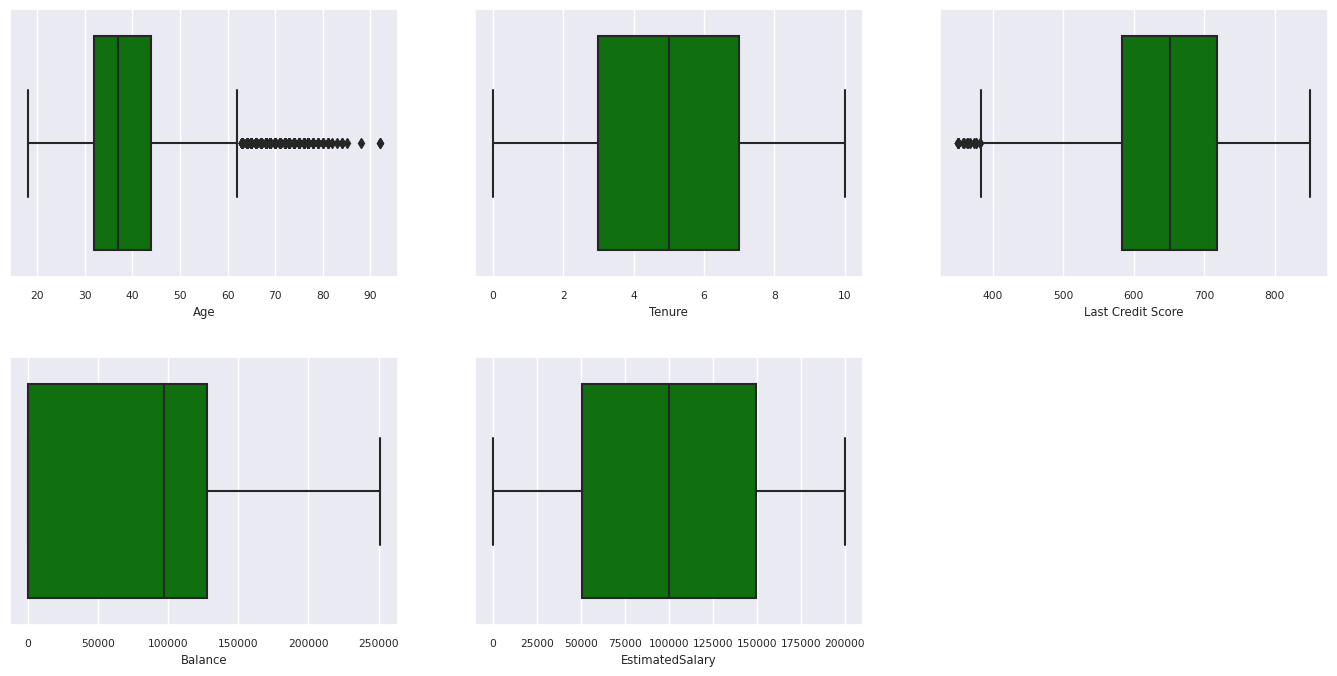

In [8]:
df_num_cols = df_clean[numeric_variables]
sns.set(font_scale = 0.7) 
fig, axes = plt.subplots(nrows = 2, ncols = 3, gridspec_kw =  dict(hspace=0.3), figsize = (17,8))
fig.tight_layout()
for ax,col in zip(axes.flatten(), df_num_cols.columns):
    sns.boxplot(x = df_num_cols[col], color='green', ax = ax)
# fig.suptitle('visualize and compare the distribution and central tendency of numerical attributes', color = 'k', fontsize = 12)
fig.delaxes(axes[1,2])


##### Distribution of exited and non-exited customers 

Show the distribution of exited versus non-exited customers across the categorical attributes.

StatementMeta(, d5f065df-11e8-423f-bb4a-27cb961a4831, 11, Finished, Available)

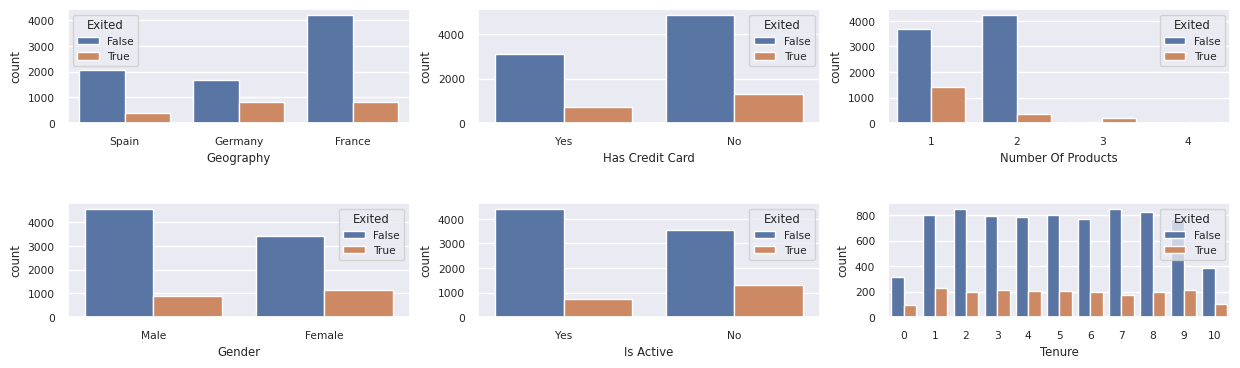

In [9]:
attr_list = ['Geography', 'Gender', 'Has Credit Card', 'Is Active', 'Number Of Products', 'Tenure']
fig, axarr = plt.subplots(2, 3, figsize=(15, 4))
for ind, item in enumerate (attr_list):
    sns.countplot(x = item, hue = 'Exited', data = df_clean, ax = axarr[ind%2][ind//2])
fig.subplots_adjust(hspace=0.7)

##### Distribution of numerical attributes

Show the the frequency distribution of numerical attributes using histogram.


StatementMeta(, d5f065df-11e8-423f-bb4a-27cb961a4831, 12, Finished, Available)

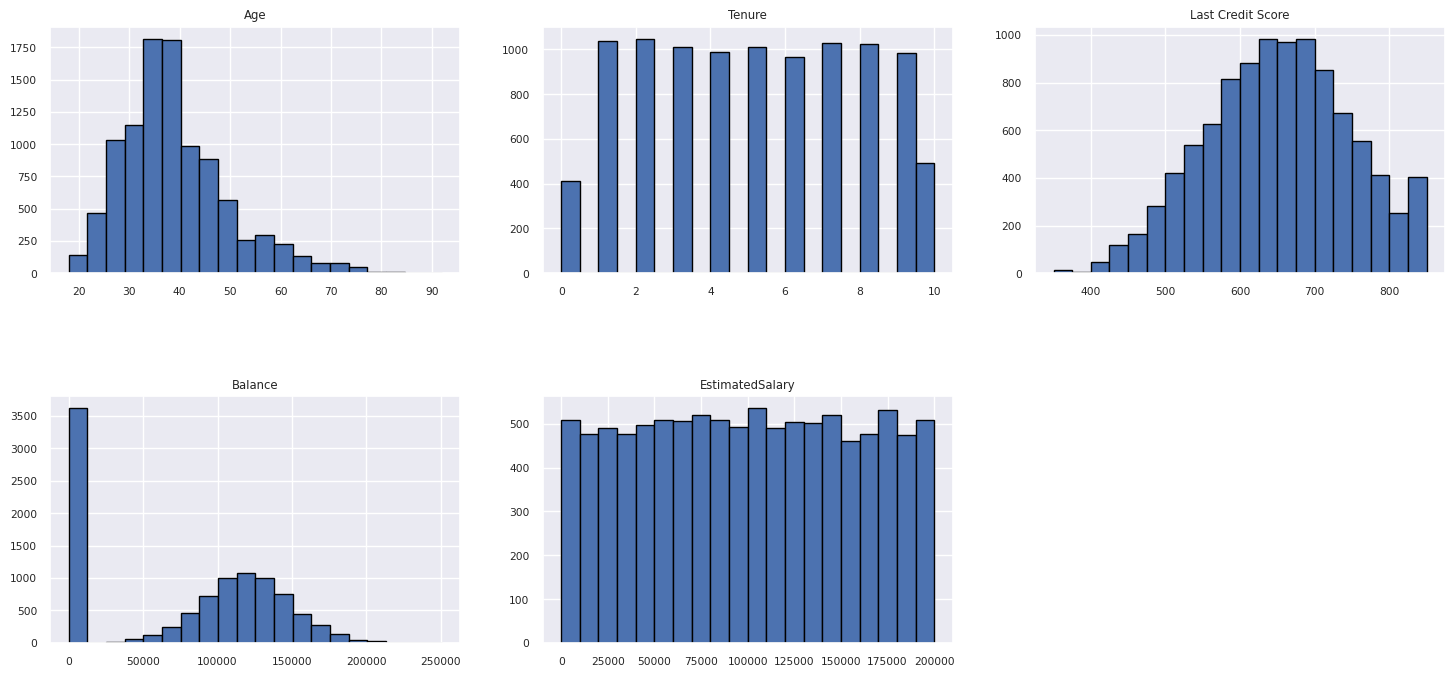

In [10]:
columns = df_num_cols.columns[: len(df_num_cols.columns)]
fig = plt.figure()
fig.set_size_inches(18, 8)
length = len(columns)
for i,j in itertools.zip_longest(columns, range(length)):
    plt.subplot((length // 2), 3, j+1)
    plt.subplots_adjust(wspace = 0.2, hspace = 0.5)
    df_num_cols[i].hist(bins = 20, edgecolor = 'black')
    plt.title(i)
# fig = fig.suptitle('distribution of numerical attributes', color = 'r' ,fontsize = 14)
plt.show()

#### Summary of observations from the exploratory data analysis

- Most of the customers are from France comparing to Spain and Germany, while Spain has the lower churn rate comparing to France and Germany.
- Most of the customers have credit cards.
- There are customers whose age and credit score are above 60 and below 400, respectively, but they can't be considered as outliers.
- Very few customers have more than two of the bank's products.
- Customers who aren't active have a higher churn rate.
- Gender and tenure years don't seem to have an impact on customer's decision to close the bank account.

### Perform feature engineering 

The following feature engineering generates new attributes based on current attributes.

In [11]:
df_clean["NewTenure"] = df_clean["Tenure"]/df_clean["Age"]
df_clean["NewCreditsScore"] = pd.qcut(df_clean['Last Credit Score'], 6, labels = [1, 2, 3, 4, 5, 6])
df_clean["NewAgeScore"] = pd.qcut(df_clean['Age'], 8, labels = [1, 2, 3, 4, 5, 6, 7, 8])
df_clean["NewBalanceScore"] = pd.qcut(df_clean['Balance'].rank(method="first"), 5, labels = [1, 2, 3, 4, 5])
df_clean["NewEstSalaryScore"] = pd.qcut(df_clean['EstimatedSalary'], 10, labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

StatementMeta(, d5f065df-11e8-423f-bb4a-27cb961a4831, 13, Finished, Available)

### Use Data Wrangler to perform one-hot encoding

Data Wrangler can also be used to perform one-hot encoding. To do so, re-open Data Wrangler. This time, select the `df_clean` data.

1. Expand `Formulas` and select `One-hot encode`.
2. A panel appears for you to select the list of columns you want to perform one-hot encoding on. Select `Geography` and `Gender`.

You could copy the generated code, close Data Wrangler to return to the notebook, then paste into a new cell. Or, select `Add code to notebook` at the top left to close Data Wrangler and add the code automatically.

<br>

<img style="float: left;" src="https://sdkstorerta.blob.core.windows.net/churnblob/1hotencoding_data_wrangler.png"  width="45%" height="20%" title="Screenshot shows one-hot encoding in the Data Wrangler"> 
<img style="float: left;" src="https://sdkstorerta.blob.core.windows.net/churnblob/1hotencoding_selectcolumns_data_wrangler.png"  width="45%" height="20%" title="Screenshot shows selection of columns in the Data Wrangler.">





##### <span style="color:red;"> Exercise 2 </span> 

In [12]:
# This is the same code that Data Wrangler will generate
 
import pandas as pd
 
def clean_data(df_clean):
    # One-hot encode columns: 'Geography', 'Gender'
    df_clean = pd.get_dummies(df_clean, columns=['Geography', 'Gender'])
    return df_clean
 
df_clean_1 = clean_data(df_clean.copy())
df_clean_1.head()

StatementMeta(, d5f065df-11e8-423f-bb4a-27cb961a4831, 14, Finished, Available)

,Age,Tenure,Has Credit Card,Is Active,Number Of Products,Last Credit Score,Balance,EstimatedSalary,Exited,NewTenure,NewCreditsScore,NewAgeScore,NewBalanceScore,NewEstSalaryScore,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,38,5,Yes,Yes,1,689,75075.140625,8651.919922,True,0.131579,4,5,3,1,False,False,True,False,True
1,43,2,Yes,Yes,1,597,85162.257812,5104.080078,True,0.046512,2,6,3,1,False,False,True,False,True
2,62,1,Yes,Yes,1,445,64119.378906,76569.640625,True,0.016129,1,8,2,4,False,False,True,False,True
3,63,1,Yes,Yes,1,695,146202.937500,126688.828125,True,0.015873,4,8,5,7,False,False,True,False,True
4,31,9,Yes,Yes,1,634,108632.476562,179485.953125,True,0.290323,3,2,3,9,False,False,True,False,True


In [13]:
# Rename columns to avoid white space
# Create a dictionary to map old column names to new column names
column_mapping = {
    "Has Credit Card": "HasCreditCard",
    "Is Active": "IsActive",
    "Number Of Products": "NumberOfProducts",
    "Last Credit Score": "LastCreditScore",
}
# Rename columns using the rename method
df_clean_2 = df_clean_1.rename(columns=column_mapping)

StatementMeta(, d5f065df-11e8-423f-bb4a-27cb961a4831, 15, Finished, Available)

Save the cleaned data to the lakehouse to be used for next step. 

In [14]:
table_name = "churn_data_clean"
# Create PySpark DataFrame from Pandas
sparkDF=spark.createDataFrame(df_clean_2) 
sparkDF.write.mode("overwrite").format("delta").save(f"Tables/{table_name}")
print(f"Spark dataframe saved to delta table: {table_name}")

StatementMeta(, d5f065df-11e8-423f-bb4a-27cb961a4831, 16, Finished, Available)

Spark dataframe saved to delta table: churn_data_clean
